# Case Study 3 : Data Mining in Image Data

**Dataset required in this case study:**
* MNIST dataset


** NOTE **
* You can directly load the dataset from keras using: `from keras.datasets import mnist`
* You may need install tensorflow and keras first: https://keras.io/


# Problem: pick a data science problem that you plan to solve using the Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

The goal is to develop a classification model that can accurately identify handwritten digits (0–9) from the MNIST dataset.
  
Automatic digit recognition is a fundamental problem in computer vision and machine learning. It has real-world applications in areas such as: Postal mail sorting; Bank check digit recognition; Digital handwriting analysis;


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
import seaborn as sns

# Data Collection/Processing:

In [2]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# Load and preprocess the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Normalize pixel values (0-255) to (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# Flatten the images for traditional ML models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


# Data Exploration: Exploring the your data

**Plot some properties/statistics/distribution of your data**

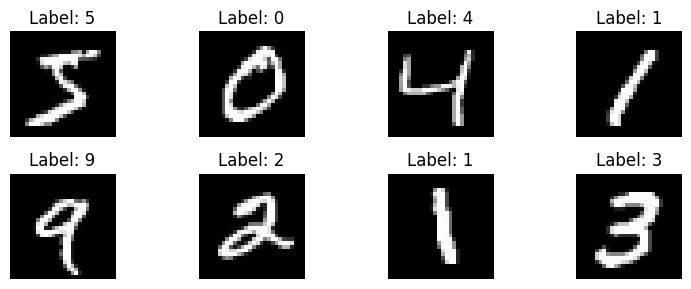

In [3]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# Visualize some sample images from the dataset
plt.figure(figsize=(8, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

**<u>Train Dataset Distribution</u>**

In [4]:
# Class distribution in the training set
count_per_class_train = pd.DataFrame(np.bincount(y_train), columns=['count'])
print(count_per_class_train)

   count
0   5923
1   6742
2   5958
3   6131
4   5842
5   5421
6   5918
7   6265
8   5851
9   5949


In [5]:
# Summary statistics of the class distribution
print("Training set class distribution summary:")
count_per_class_train.describe()

Training set class distribution summary:


,count
count,10.000000
mean,6000.000000
std,339.505196
min,5421.000000
25%,5867.750000
50%,5936.000000
75%,6087.750000
max,6742.000000


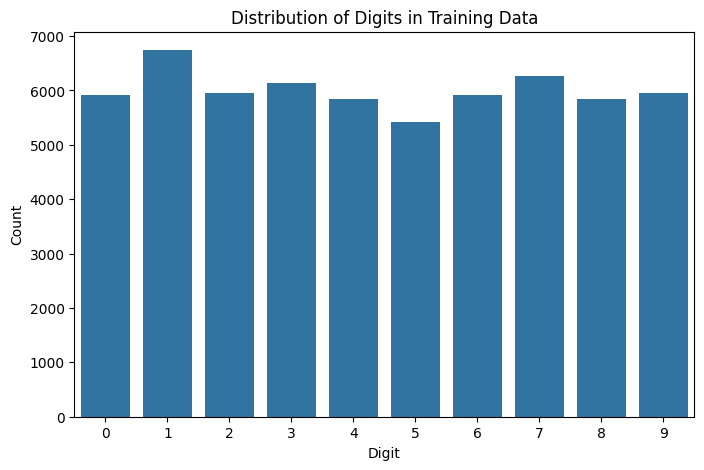

In [6]:
# Distribution of digits (class balance)
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train)
plt.title("Distribution of Digits in Training Data")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


The training dataset is fairly balanced — each digit has roughly 5,400–6,700 samples, with only small variations across classes.
Digit 1 has the highest count (6742), while digit 5 has the lowest (5421).

**<u>Test Dataset Distribution</u>**

In [7]:
count_per_class_test = pd.DataFrame(np.bincount(y_test), columns=['count'])
print(count_per_class_test)

   count
0    980
1   1135
2   1032
3   1010
4    982
5    892
6    958
7   1028
8    974
9   1009


In [8]:
print("Test set class distribution summary:")
count_per_class_test.describe()

Test set class distribution summary:


,count
count,10.000000
mean,1000.000000
std,62.398362
min,892.000000
25%,975.500000
50%,995.500000
75%,1023.500000
max,1135.000000


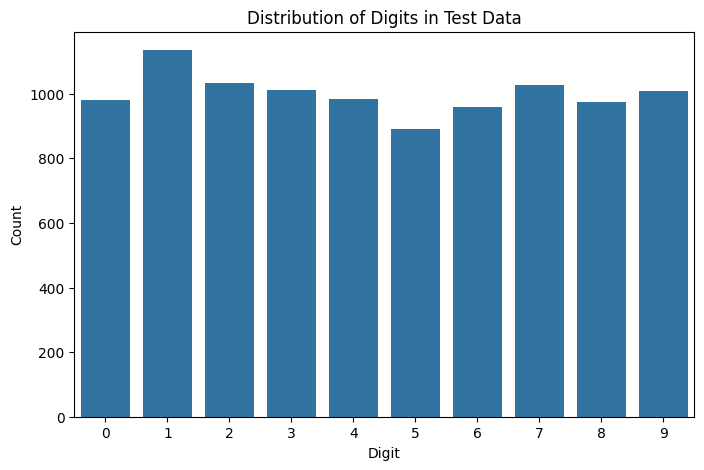

In [9]:
# Distribution of digits (class balance)
plt.figure(figsize=(8, 5))
sns.countplot(x=y_test)
plt.title("Distribution of Digits in Test Data")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

The MNIST test dataset is well-balanced across all 10 digit classes. The number of samples per class ranges from 892 (digit 5) to 1135 (digit 1), showing only minor differences.

Such balance ensures that model evaluation metrics like accuracy provide a fair measure of performance across all digits

**<u>Pixel Intensity</u>**

Pixel values range: 0.0 to 1.0


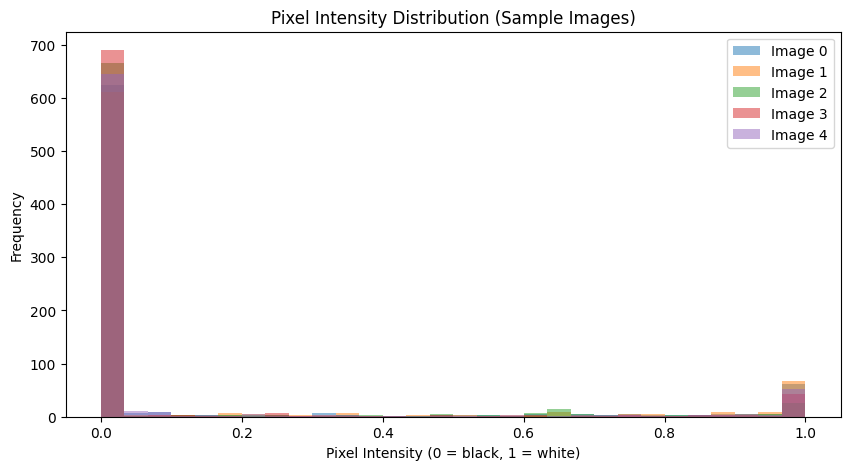

In [10]:
# Pixel intensity statistics
print(f"Pixel values range: {X_train.min()} to {X_train.max()}")

# Plot histogram of pixel intensities for a few images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.hist(X_train[i].ravel(), bins=30, alpha=0.5, label=f'Image {i}')
plt.title("Pixel Intensity Distribution (Sample Images)")
plt.xlabel("Pixel Intensity (0 = black, 1 = white)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


- Most pixels have intensity values close to 0 (black) — these correspond to the background of the images.

- A smaller number of pixels have higher intensity values (closer to 1, white) — these form the digit strokes.

- This distribution confirms that the dataset primarily contains sparse, black-background images with bright pixel regions forming the handwritten digits.

# The Solution: implement data science solutions to the problem you are trying to solve.

Briefly describe the idea of your solutions to the problem in the following cell (please use at least 3 different  models including at least one deep learning model to solve your problem and compare the results):

To solve this problem, I implemented and compared three different models:

1) Logistic Regression: A simple linear model that serves as a baseline. It treats each pixel as an independent feature and learns weights for classification.

2) Random Forest Classifier: An ensemble of decision trees that captures nonlinear relationships and interactions between pixels.

3) Feedforward Deep Learning Model (Neural Network):
A multilayer perceptron (MLP) that automatically learns complex patterns in the pixel data.
  - *Architecture*: Flatten → Dense(128, relu) → Dense(64, relu) → Dense(10, softmax)
  - *Optimizer*: SGD
  - *Loss*: Categorical cross-entropy
  - *Metric*: Accuracy

Write codes to implement the solution in python:

##### 1. Logistic regression Model

In [11]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_flat, y_train)

LogisticRegression(max_iter=1000)

##### 2. Random Forest Model

In [12]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

RandomForestClassifier(random_state=42)

##### 3. Deep Learning Model

In [13]:
# Convert labels to one-hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# A simple feedforward neural network
dl_model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

dl_model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

history = dl_model.fit(X_train, y_train_cat, epochs=5, batch_size=128, validation_split=0.1, verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4425 - loss: 1.8566 - val_accuracy: 0.8697 - val_loss: 0.6286
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8477 - loss: 0.6078 - val_accuracy: 0.9048 - val_loss: 0.3767
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8835 - loss: 0.4281 - val_accuracy: 0.9183 - val_loss: 0.3116
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8949 - loss: 0.3729 - val_accuracy: 0.9228 - val_loss: 0.2818
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9022 - loss: 0.3448 - val_accuracy: 0.9277 - val_loss: 0.2628


In [14]:
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "Deep Learning Model": dl_model
}
results = {}
for name, model in models.items():
    if name == "Deep Learning Model":
        X_test_reshaped = X_test_flat.reshape(-1, 28, 28)
        _, test_acc = model.evaluate(X_test_reshaped, y_test_cat)
        results[name] = test_acc
        print(f"finished training {name}")
    else:
      y_pred = model.predict(X_test_flat)
      results[name] = accuracy_score(y_test, y_pred)
      print(f"finished training {name}")

finished training Logistic Regression
finished training Random Forest
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9003 - loss: 0.3470
finished training Deep Learning Model


# Results: summarize and visualize the results discovered from the analysis

Please use figures or tables to present the results.


In [15]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print(results_df)

                 Model  Accuracy
1        Random Forest    0.9704
0  Logistic Regression    0.9259
2  Deep Learning Model    0.9136


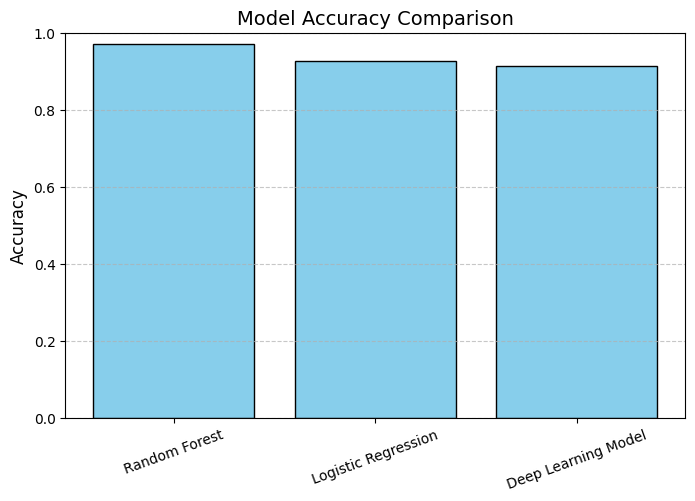

In [16]:
# Bar chart of accuracies
plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['Accuracy'], color='skyblue', edgecolor='black')
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)  # accuracy range (0–1)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Random Forest provided the best accuracy among the tested models. The Deep Learning Model (Feedforward Neural Network) reached an accuracy of 91%, which is slightly lower; mainly because it’s a simple dense network trained for only a few epochs using basic optimization (SGD). Deep learning methods have the potential to generalize better when the network architecture and training setup are more sophisticated.

*-----------------
# Done

All set!

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and submit it in BrightSpace.Please make sure all the plotted tables and figures are in the notebook.